In [2]:
import numpy as np
import os
import pandas as pd
import itertools

from collections import OrderedDict
from tqdm.notebook import tqdm

# import pmi_accuracy.parser as parser
from pmi_accuracy.conll_data import CONLLReader, EXCLUDED_PUNCTUATION, CONLL_COLS

In [31]:
import sys
print(sys.path)

['/Users/j/McGill/PhD-miasma/pmi-dependencies', '/Users/j/anaconda3/envs/pmienv/lib/python37.zip', '/Users/j/anaconda3/envs/pmienv/lib/python3.7', '/Users/j/anaconda3/envs/pmienv/lib/python3.7/lib-dynload', '', '/Users/j/.local/lib/python3.7/site-packages', '/Users/j/anaconda3/envs/pmienv/lib/python3.7/site-packages', '/Users/j/anaconda3/envs/pmienv/lib/python3.7/site-packages/IPython/extensions', '/Users/j/.ipython']


In [3]:
lstm_logp_matrices = np.load('lstm-vs-onlstm/lstm_logp_matrices.npz')
onlstm_logp_matrices = np.load('lstm-vs-onlstm/onlstm_logp_matrices.npz')
onlstm_syd_logp_matrices = np.load('lstm-vs-onlstm/onlstm_syd_logp_matrices.npz')

We are calculating pmi matrix, where this is

$$\mathrm{PMI}({\bf w}_I;{\bf w}_J\mid {\bf w}_{0:J-1,J+1:I-1}) = 
\log \frac{p({\bf w}_I\mid  {\bf w}_{0:I-1})}
          {p({\bf w}_I\mid {\bf w}_{0:J-1,J+1:I-1})} = \log(unmasked) - \log(masked)$$
where ${\bf w}_{0:J-1,J+1:I-1}$ is the sentence up to ${\bf w}_I$, without ${\bf w}_J$.

--

The logp matrices are interpreted as follows: the value in row $r$, column $c$ is the estimated logp of word c+1 when word $r$ is masked.

that is

- in row $r$ we have masked the token in position $r$.
- in column $c$ are logprobabilities for the word in position $c+1$ (so there is one fewer columns than rows).
- if sentence length (without punctuation) $=n$ tokens, then the logp matrix is of size $(n+2)$-by-$(n+1)$, because an `<eos>` token is appended to the beginning and end of the sentence.


So, the final row in the logp matrix is the row of logps with _no masking_ (bc it is masking last element, which isn't seen by model).  So this is our pmi numerator. The entry at position $r,c$ is the logp of word at position $c+1$ when word at position $r$ is masked, so that gives the numerator for PMI.  Also, summin across this row of logps gives an pseudo loglikelihood for the sentence.

Note we don't care about masking of `<eos>`, so we will ignore the first row, as well as the last, and we don't care about predictions of `<eos>`, so we'll aslo drop the the last column.

**For consistency with the other PMI matrices, where rows correspond to target word, columns to masked word, we will transpose this result (so bottom triangle is nonzero).**

In [7]:
def pmi_matrix_from_logp_matrix(input_logp_matrix, transpose=True):
    """Convert nparray of logps to pmi matrix"""
    logp_matrix = input_logp_matrix[:, :-1]  # drop last column
    logp_unmasked = logp_matrix[-1]  # last row is unmasked logps
    # dropping first and last row, subtract from unmasked logps
    pmimat = logp_unmasked - logp_matrix[1:-1]
    if transpose:
        pmimat = pmimat.T
    return pmimat


# print('for example')
# with np.printoptions(precision=2, suppress=True):
#     testsen = lstm_logp_matrices.files[1276]
#     testmat = lstm_logp_matrices[testsen]
#     testpmimat = pmi_matrix_from_logp_matrix(testmat)
#     print(
#         testsen,
#         pmi_matrix_from_logp_matrix(testmat),
#         sep='\n')

In [6]:
# counter = 0
# for i_sen in lstm_logp_matrices:
#     if len(i_sen.split(' ')) < 6 or len(i_sen.split(' ')) > 7:
#         continue
#     counter += 1
#     logp_matrix = lstm_logp_matrices[i_sen]
#     print(logp_matrix.shape)
#     pmi_matrix = pmi_matrix_from_logp_matrix(logp_matrix)
#     with np.printoptions(precision=2, suppress=True):
#         print(pmi_matrix, i_sen)
#     if counter == 4:
#         break


# Alignment...
We've got to align these results with the dependency information from the conll files.

In [8]:
CONNLX_FILE = 'ptb3-wsj-data/ptb3-wsj-dev.conllx'
OBSERVATIONS = CONLLReader(CONLL_COLS).load_conll_dataset(CONNLX_FILE)

In [11]:
# for example, see how they differ from the XLNet sentences:
XLNET = "results-clean/contextual_embedding_models/xlnet-base-cased_pad30_2020-08-07-09-12/"
XLNET_mats = np.load(os.path.join(XLNET, 'pmi_matrices.npz')) # just for comparison

for i in [128,1276,1185]:
    print(XLNET_mats.files[i]) # same as print(i, ' '.join(OBSERVATIONS[i].sentence))
    print(onlstm_syd_logp_matrices.files[i])

128 Revenue fell 1 % to $ 1.39 billion from $ 1.41 billion .
128 <eos> revenue fell N % to N.N billion from N.N billion <eos>
1276 Source : Telerate Systems Inc .
1276 <eos> source telerate systems inc <eos>
1185 Other components of the long leading indicator include a ratio of prices to unit labor costs in manufacturing industries , the M2 version of the money supply , adjusted for inflation , and the volume of new home-building permits .
1185 <eos> other components of the long leading indicator include a ratio of prices to unit labor costs in manufacturing industries the mN version of the money supply adjusted for inflation and the volume of new home-building permits <eos>


In [12]:
def matches(PTB_word, simple_word):
    simple_word = simple_word.replace("\\/", "/")
    if PTB_word.lower() == simple_word:
        return True
    Nified_PTB_word = ''.join(
        'N' if b else "".join(x)
        for b, x in itertools.groupby(
            PTB_word.lower(), key=str.isdigit))
    if simple_word == Nified_PTB_word:
        return True
    else:
        return False


def realign_to_ptb(observation, sent_simple, pmi_matrix_simple):
    count = 0
    new_lstm_sent = []
    for j, w in enumerate(observation.sentence):
        match = ''
        if count >= len(sent_simple):
            pass
        elif matches(w, sent_simple[count]):
            match = sent_simple[count]
            count += 1
        new_lstm_sent.append(match)

    extra_slots = [i for i, x in enumerate(new_lstm_sent) if x == '']
    new_observation = observation
    new_observation = new_observation._replace(
        extra_info = observation.sentence,
        sentence = new_lstm_sent)

    # insert NaNs in the rows and columns where blanks are
    new_pmi_matrix = pmi_matrix_simple
    for k in extra_slots:
        for axis in [0, 1]:
            new_pmi_matrix = np.insert(
                arr=new_pmi_matrix, obj=k, values=np.NaN,
                axis=axis)

    return new_pmi_matrix, new_observation

In [14]:
# # Looking at some examples
# for i in [128, 1276, 1185]:
#     obs_i = OBSERVATIONS[i]
#     simplesent_i = lstm_logp_matrices.files[i].split(' ')[2:-1]
#     simplemat_i = pmi_matrix_from_logp_matrix(
#         lstm_logp_matrices[lstm_logp_matrices.files[i]])

#     newmat, newobs = realign_to_ptb(obs_i, simplesent_i, simplemat_i)
#     print(newobs.sentence)
#     blanked_sent = ['' if w==None else w for w in newobs.sentence]
#     mstparser1 = parser.DepParse('mst', newmat, newobs.sentence)
#     mstparser2 = parser.DepParse('mst', newmat, blanked_sent)
    
#     df = pd.DataFrame(newobs).T
#     df.columns = CONLL_COLS
#     display(df)
#     print(newmat.shape)

Note that if we use the original sentence, we get edges between words which are `$`, since I treated this as a word, and the LSTM code treats it as a punctuation and does not train on it.  So we should get the gold score including `$` in the list of excluded punctuation. To do this, I've replaced the `sentence` field with the blanked-out sentence, and put the original sentence in `extra_info`.

# Export new matrices

In [15]:
def get_aligned_pmi_matrices_from_logp(logp_matrices, observations):
    matrices_orddict = OrderedDict()
    loglik_orddict = OrderedDict()
    for sent_key in tqdm(logp_matrices.files):
        i = int(sent_key.split(' ')[0])
        logp_matrix = logp_matrices[sent_key]
        simple_sent = sent_key.split(' ')[2:-1]
        simple_pmis = pmi_matrix_from_logp_matrix(logp_matrix)
        obs = observations[i]
        spaced_pmis, spaced_obs = realign_to_ptb(
            obs, simple_sent, simple_pmis)
#         key_i = str(' '.join([str(i), *spaced_obs.sentence]))
        key_i = str(' '.join([str(i), *obs.sentence]))
        matrices_orddict[key_i] = spaced_pmis
        pseudo_loglik = np.sum(logp_matrix[-1])
        loglik_orddict[key_i] = pseudo_loglik
        if spaced_pmis.shape[0]!=len(obs.sentence):
            print("mismatch at",i,
                  f"{spaced_pmis.shape[0]}!={len(obs.sentence)}")
    return(matrices_orddict, loglik_orddict)
#         with np.printoptions(precision=1, suppress=True):
#             print(simple_sent,simple_pmis,
#                   spaced_obs.sentence,spaced_pmis,sep='\n')

In [20]:
lstm_pmi_matrices, lstm_pmi_logliks = get_aligned_pmi_matrices_from_logp(
    lstm_logp_matrices, OBSERVATIONS)
onlstm_pmi_matrices, onlstm_pmi_logliks = get_aligned_pmi_matrices_from_logp(
    onlstm_logp_matrices, OBSERVATIONS)
onlstm_syd_pmi_matrices, onlstm_syd_pmi_logliks = get_aligned_pmi_matrices_from_logp(
    onlstm_syd_logp_matrices, OBSERVATIONS)

In [29]:
def write_npz(
        ordered_dict, resultsdir,
        outfilename='saved.npz'):
    save_filepath = os.path.join(resultsdir, outfilename)
    np.savez(save_filepath, **ordered_dict)

npzs_dirs = [
    [lstm_pmi_matrices, 'lstm-vs-onlstm/lstm/', "pmi_matrices.npz"],
    [lstm_pmi_logliks, 'lstm-vs-onlstm/lstm/', "pseudo_logliks.npz"],
    [onlstm_pmi_matrices, 'lstm-vs-onlstm/onlstm/', "pmi_matrices.npz"],
    [onlstm_pmi_logliks, 'lstm-vs-onlstm/onlstm/', "pseudo_logliks.npz"],
    [onlstm_syd_pmi_matrices, 'lstm-vs-onlstm/onlstm_syd/', "pmi_matrices.npz"],
    [onlstm_syd_pmi_logliks, 'lstm-vs-onlstm/onlstm_syd/', "pseudo_logliks.npz"]]

for i in npzs_dirs:
    write_npz(i[0], i[1], outfilename=i[2])
    print("NPZs written to",i[1])

NPZs written to lstm-vs-onlstm/lstm/
NPZs written to lstm-vs-onlstm/lstm/
NPZs written to lstm-vs-onlstm/onlstm/
NPZs written to lstm-vs-onlstm/onlstm/
NPZs written to lstm-vs-onlstm/onlstm_syd/
NPZs written to lstm-vs-onlstm/onlstm_syd/


# Analysis

In [51]:
import pandas as pd
results_df = pd.read_csv('lstm-vs-onlstm/results.csv') # entered by hand.
pd.pivot_table(
    results_df, 
    values='uuas', index=['model'], columns=['absolute_value','algorithm'])

absolute_value   False          True        
algorithm      nonproj   proj nonproj   proj
model                                       
lstm             0.420  0.458   0.435  0.469
onlstm           0.425  0.461   0.439  0.472
onlstm_syd       0.428  0.464   0.442  0.475

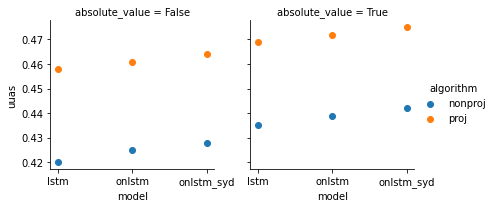

In [52]:
import seaborn as sns
g = sns.FacetGrid(results_df, col="absolute_value", hue="algorithm")
g = (g.map(plt.scatter, "model", "uuas").add_legend())

## Looking at the sentences

In [175]:
s1 = pd.Series(lstm_logp_matrices.files, name='simplified')
s2 = pd.Series(xlnet_pmi_matrices.files, name='not simplified')
sent_comparison = pd.concat([s1, s2], axis=1)
pd.set_option('display.max_colwidth', None)
sent_comparison.head()

,simplified,not simplified
0,0 <eos> influential members of the house ways and means committee introduced legislation that would restrict how the new savings-and-loan bailout agency can raise capital creating another potential obstacle to the government 's sale of sick thrifts <eos>,"0 Influential members of the House Ways and Means Committee introduced legislation that would restrict how the new savings-and-loan bailout agency can raise capital , creating another potential obstacle to the government 's sale of sick thrifts ."
1,1 <eos> the bill whose backers include chairman dan rostenkowski d. ill. would prevent the resolution trust corp. from raising temporary working capital by having an rtc-owned bank or thrift issue debt that would n't be counted on the federal budget <eos>,"1 The bill , whose backers include Chairman Dan Rostenkowski -LRB- D. , Ill. -RRB- , would prevent the Resolution Trust Corp. from raising temporary working capital by having an RTC-owned bank or thrift issue debt that would n't be counted on the federal budget ."
2,2 <eos> the bill intends to restrict the rtc to treasury borrowings only unless the agency receives specific congressional authorization <eos>,"2 The bill intends to restrict the RTC to Treasury borrowings only , unless the agency receives specific congressional authorization ."
3,3 <eos> such agency self-help borrowing is unauthorized and expensive far more expensive than direct treasury borrowing said rep. fortney stark d. calif. the bill 's chief sponsor <eos>,"3 `` Such agency ` self-help ' borrowing is unauthorized and expensive , far more expensive than direct Treasury borrowing , '' said Rep. Fortney Stark -LRB- D. , Calif. -RRB- , the bill 's chief sponsor ."
4,4 <eos> the complex financing plan in the s&l bailout law includes raising N billion from debt issued by the newly created rtc <eos>,4 The complex financing plan in the S&L bailout law includes raising $ 30 billion from debt issued by the newly created RTC .


In [177]:
sent_comparison.loc[396:400]

,simplified,not simplified
396,396 <eos> bsn corp. said it will begin an offer tomorrow to exchange up to one million of its common shares and all of its N.N million in N N\/N % convertible debentures due N for a package of new debt and common stock warrants <eos>,396 BSN Corp. said it will begin an offer tomorrow to exchange up to one million of its common shares and all of its $ 16.6 million in 7 3/4 % convertible debentures due 2001 for a package of new debt and common stock warrants .
397,397 <eos> under terms of the offer the sporting goods maker will swap N face amount of N N\/N % subordinated notes due N and one warrant for each common share <eos>,"397 Under terms of the offer , the sporting goods maker will swap $ 9 face amount of 9 1/4 % subordinated notes due 1996 and one warrant for each common share ."
398,398 <eos> each warrant allows the holder to buy one bsn share for N.N a share at any time over the next seven years <eos>,398 Each warrant allows the holder to buy one BSN share for $ 10.75 a share at any time over the next seven years .
399,399 <eos> bsn currently has N.N million common shares outstanding <eos>,399 BSN currently has 4.6 million common shares outstanding .
400,"400 <eos> bsn also is offering N face amount of new notes and N common-stock warrants for each N,N face amount of its convertible debt outstanding <eos>","400 BSN also is offering $ 850 face amount of new notes and 64 common-stock warrants for each $ 1,000 face amount of its convertible debt outstanding ."


In [176]:
sent_comparison.loc[127:130]

,simplified,not simplified
127,127 <eos> average shares outstanding dropped to N.N million from N.N million <eos>,127 Average shares outstanding dropped to 75.8 million from 82.1 million .
128,128 <eos> revenue fell N % to N.N billion from N.N billion <eos>,128 Revenue fell 1 % to $ 1.39 billion from $ 1.41 billion .
129,129 <eos> the computer maker which sells more than half its goods outside the u.s. also said the negative effect of a stronger u.s. dollar will adversely affect its fourth-quarter performance and make it difficult to better N results <eos>,"129 The computer maker , which sells more than half its goods outside the U.S. , also said the negative effect of a stronger U.S. dollar will `` adversely affect '' its fourth-quarter performance and `` make it difficult '' to better 1988 results ."
130,130 <eos> ncr said revenue declined both in the u.s. and overseas reflecting a world-wide softening of the computer markets <eos>,"130 NCR said revenue declined both in the U.S. and overseas , reflecting a world-wide softening of the computer markets ."


In [178]:
sent_comparison.loc[150:151]

,simplified,not simplified
150,150 <eos> i had calls all night long from the states he said <eos>,"150 `` I had calls all night long from the States , '' he said ."
151,151 <eos> i was woken up every hour N:N N:N N:N N:N <eos>,"151 `` I was woken up every hour -- 1:30 , 2:30 , 3:30 , 4:30 ."


## Plot

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_pmi_plot(sent, mat, fig=None, ax=None, title=None):
    lim = max(abs(np.min(mat)), abs(np.max(mat)))
    if ax is None:
        fig, ax = plt.subplots()
    cax = ax.matshow(
        mat, cmap='PuOr',
        norm=colors.TwoSlopeNorm(vcenter=0, vmin=-lim, vmax=lim))
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cax, cax=cax1)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.tick_params(axis="x", labelrotation=40)
    ax.set_xlabel('w2 (masked/unmasked conditioner)')
    ax.set_ylabel('w1 (target)')
    ax.yaxis.set_label_position("left")
    if title is not None:
        ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=35,
             ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=35,
             ha="right", rotation_mode="anchor")
    plt.show()
    
def plot_pmi_matrix(key_sen,pmi_matrix):
    sentence = key_sen.split(' ')[1:]
    print(sentence)
    show_pmi_plot(sent=sentence, mat=pmi_matrix)

lstm
['The', 'complex', 'financing', 'plan', 'in', 'the', 'S&L', 'bailout', 'law', 'includes', 'raising', '$', '30', 'billion', 'from', 'debt', 'issued', 'by', 'the', 'newly', 'created', 'RTC', '.']


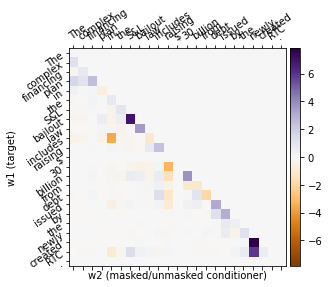

onlstm
['The', 'complex', 'financing', 'plan', 'in', 'the', 'S&L', 'bailout', 'law', 'includes', 'raising', '$', '30', 'billion', 'from', 'debt', 'issued', 'by', 'the', 'newly', 'created', 'RTC', '.']


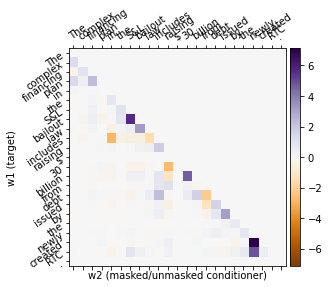

onlstm_syd
['The', 'complex', 'financing', 'plan', 'in', 'the', 'S&L', 'bailout', 'law', 'includes', 'raising', '$', '30', 'billion', 'from', 'debt', 'issued', 'by', 'the', 'newly', 'created', 'RTC', '.']


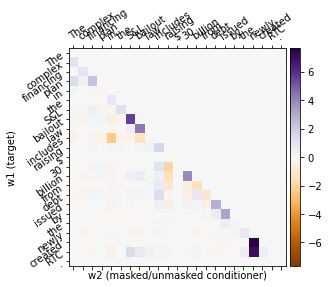

onlstm_syd_mat - lstm_mat
['The', 'complex', 'financing', 'plan', 'in', 'the', 'S&L', 'bailout', 'law', 'includes', 'raising', '$', '30', 'billion', 'from', 'debt', 'issued', 'by', 'the', 'newly', 'created', 'RTC', '.']


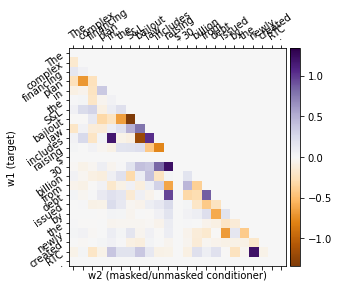

onlstm_syd_mat - onlstm_mat
['The', 'complex', 'financing', 'plan', 'in', 'the', 'S&L', 'bailout', 'law', 'includes', 'raising', '$', '30', 'billion', 'from', 'debt', 'issued', 'by', 'the', 'newly', 'created', 'RTC', '.']


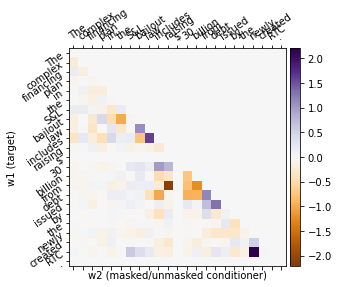

In [26]:
i=4
key = list(lstm_pmi_matrices.keys())[i]
lstm_mat = np.nan_to_num(lstm_pmi_matrices[key])
onlstm_mat = np.nan_to_num(onlstm_pmi_matrices[key])
onlstm_syd_mat = np.nan_to_num(onlstm_syd_pmi_matrices[key])
print('lstm')
plot_pmi_matrix(key, lstm_mat)
print('onlstm')
plot_pmi_matrix(key, onlstm_mat)
print('onlstm_syd')
plot_pmi_matrix(key, onlstm_syd_mat)
print('onlstm_syd_mat - lstm_mat')
plot_pmi_matrix(key, onlstm_syd_mat - lstm_mat)
print('onlstm_syd_mat - onlstm_mat')
plot_pmi_matrix(key, onlstm_syd_mat - onlstm_mat)